In [2]:
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
'''from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import nms'''


In [3]:
def timeSince (since):
    def timeSince(since):
        """
        Calculate the time elapsed since a given timestamp.

        Parameters:
        since (float): The timestamp to calculate the time elapsed from.

        Returns:
        str: A formatted string representing the time elapsed in minutes and seconds.
        """
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_path = 'unet_model.pth'

cpu


In [5]:
image_path = (r'C:\Users\USER\Documents\seismic\images')
mask_path = (r'C:\Users\USER\Documents\seismic\masks')

In [6]:
os.listdir(mask_path)

['000e218f21.png',
 '003c477d7c.png',
 '00441f1cf2.png',
 '0050766ae2.png',
 '005b452274.png',
 '0061281eea.png',
 '008a50a2ec.png',
 '00950d1627.png',
 '00a3af90ab.png',
 '00cda0328c.png',
 '0108518d1e.png',
 '010ee525b6.png',
 '0115703825.png',
 '01323211a0.png',
 '016fc8031c.png',
 '019afb4b4e.png',
 '01b5362cce.png',
 '01c033e116.png',
 '01c2045d03.png',
 '020376e68e.png',
 '020678ec1b.png',
 '02117a400e.png',
 '021494f3aa.png',
 '02206b234e.png',
 '022b1b01be.png',
 '023d486fba.png',
 '0243477802.png',
 '0249c49180.png',
 '026b509cd4.png',
 '026f97575b.png',
 '0280db420c.png',
 '0280deb8ae.png',
 '029c321179.png',
 '02adf272e9.png',
 '02d40993ab.png',
 '03049b14ca.png',
 '0304e9ac37.png',
 '03511989ac.png',
 '0389fc6012.png',
 '03a9a9f615.png',
 '03be56aa9a.png',
 '03c9b5ffe8.png',
 '03eed26d3e.png',
 '0401ae15d3.png',
 '04182ced8e.png',
 '041925f04c.png',
 '04234be388.png',
 '0429d9759b.png',
 '042c3d4e03.png',
 '04315b9a64.png',
 '044106f759.png',
 '045c5516a2.png',
 '0461a2fb30

In [7]:
names = ['6caec01e67','2bfa664017','1544a0e952']
images = [Image.open(os.path.join(image_path, name+ '.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+ '.png')) for name in names]

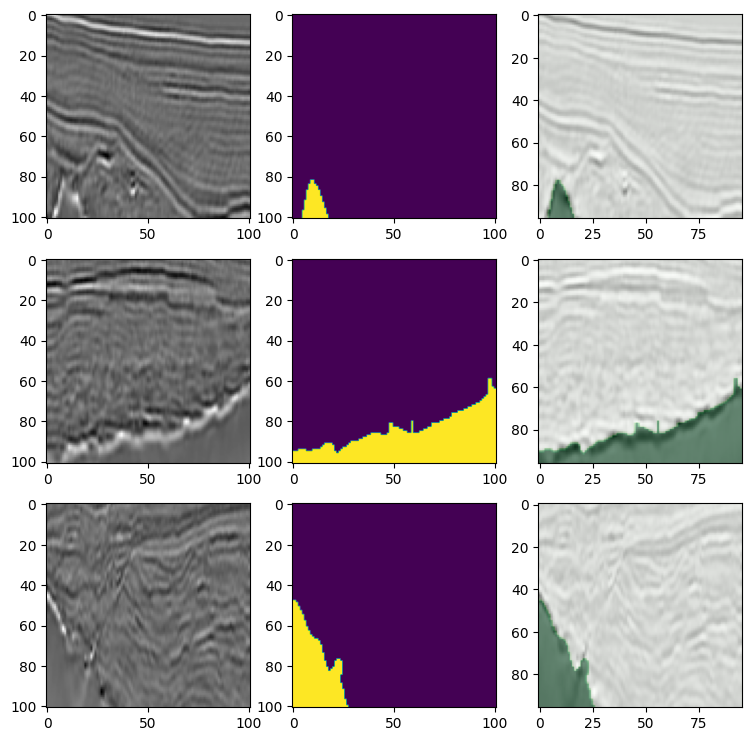

In [8]:
transforms = T.Compose([
    T.Grayscale(),
    T.Resize((96, 96)),  # Ensure a consistent size for inputs and targets
    T.ToTensor()
])

X = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])


fig = plt.figure( figsize= (9,9))

ax = fig.add_subplot(331)
plt.imshow(images[0])
ax = fig.add_subplot(332)
plt.imshow(masks[0])
ax= fig.add_subplot(333)
ax.imshow(X[0].squeeze(), cmap= 'Greys')
ax.imshow(y[0].squeeze(), alpha= 0.5, cmap= 'Greens')

ax = fig.add_subplot(334)
plt.imshow(images[1])
ax = fig.add_subplot(335)
plt.imshow(masks[1])
ax= fig.add_subplot(336)
ax.imshow(X[1].squeeze(), cmap= 'Greys')
ax.imshow(y[1].squeeze(), alpha= 0.5, cmap= 'Greens')

ax = fig.add_subplot(337)
plt.imshow(images[2])
ax = fig.add_subplot(338)
plt.imshow(masks[2])
ax= fig.add_subplot(339)
ax.imshow(X[2].squeeze(), cmap= 'Greys')
ax.imshow(y[2].squeeze(), alpha= 0.5, cmap= 'Greens')

In [38]:
def load_images_and_mask(image_path, mask_path):
    data = []
    filenames = sorted(os.listdir(image_path))
    for name in filenames:
        # Load image and mask
        image = np.array(Image.open(os.path.join(image_path, name)).convert('L'))
        mask = np.array(Image.open(os.path.join(mask_path, name)).convert('L'))
        
        # Append to the dataset
        data.append({'image': image, 'mask': mask})
    # Create DataFrame
    df = pd.DataFrame(data)
    return df


In [37]:
class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        mask = self.df.iloc[idx]['mask']

        # Convert to tensors, normalize to [0, 1], and set dtype to float32
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Add channel dim
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0    # Add channel dim
        return image, mask






In [23]:
df = load_images_and_mask(image_path, mask_path)
dataset = DataFrameDataset(df)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Viewing dataset dimension
for batch_images, batch_masks in dataloader:
    print(batch_images.shape, batch_masks.shape)
    break

print(dataloader)

torch.Size([4, 1, 101, 101]) torch.Size([4, 1, 101, 101])


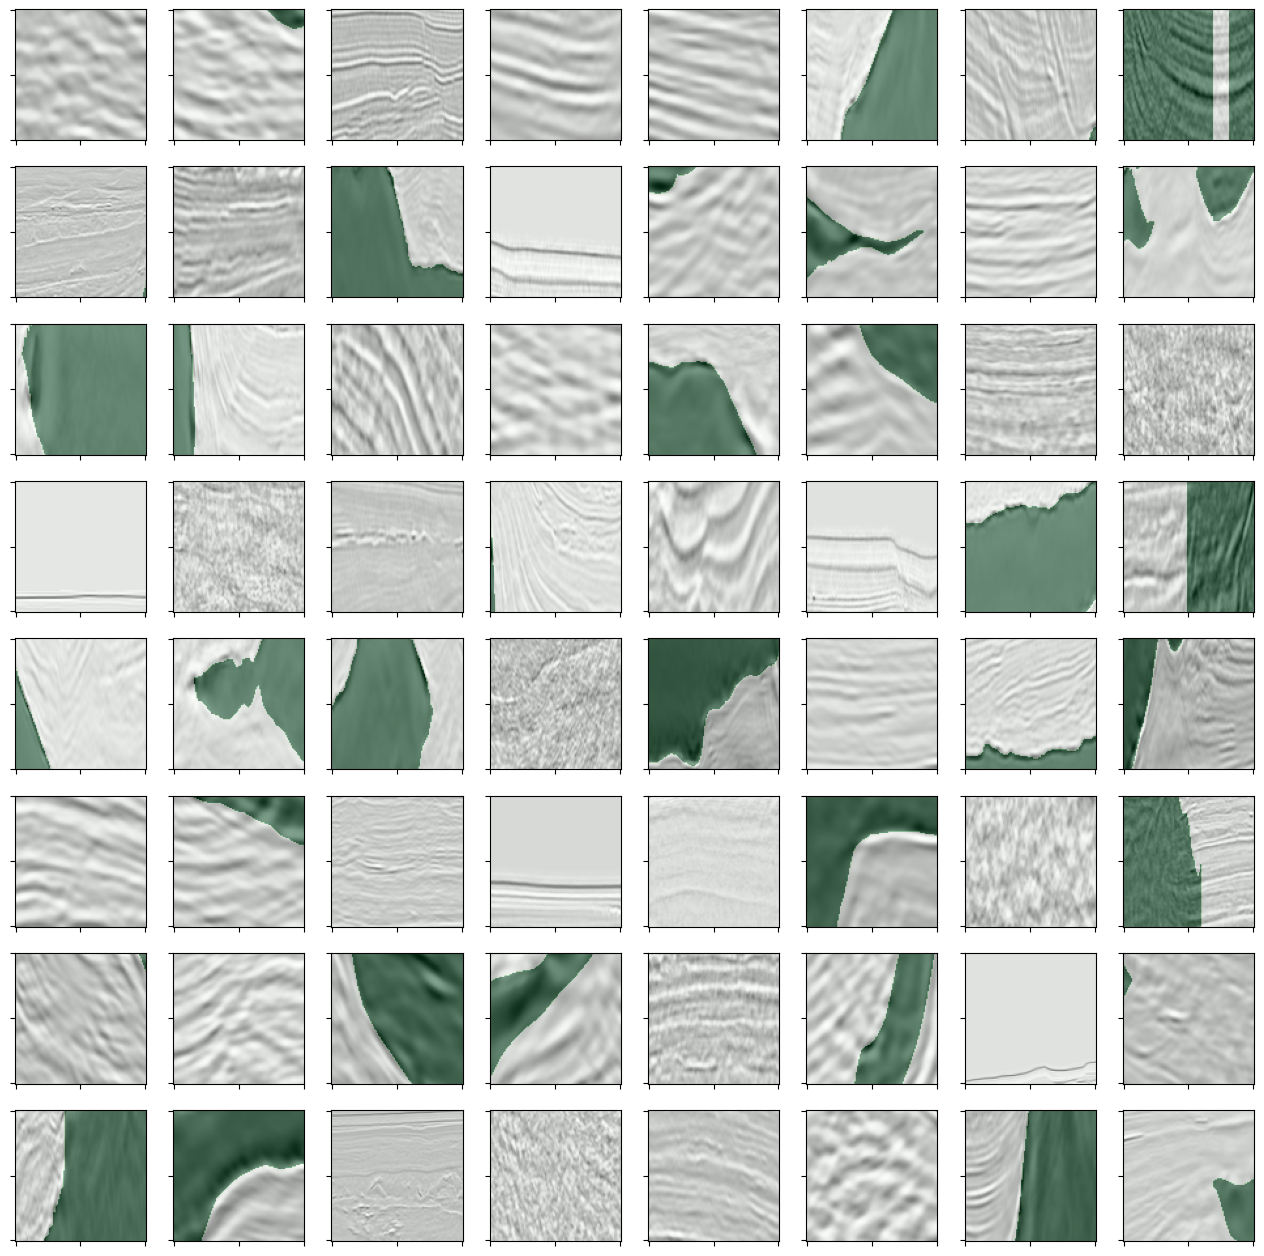

In [24]:
# Plotting loaded and transformed trainset images
max_images = 64
grid_width = 8

grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(range(max_images)):
    image, mask = dataset[idx]

    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")

    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show()

In [31]:
# Helper function for convolutional blocks
def conv_block(in_channels, out_channels, kernel_size=3, padding=1, dropout=0.0):
    """
    Creates a convolutional block consisting of multiple layers.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
        padding (int, optional): Amount of padding. Defaults to 1.
        dropout (float, optional): Dropout probability. Defaults to 0.0.

    Returns:
        nn.Sequential: Sequential container of the convolutional layers.
    """
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

# Helper function for residual blocks
def residual_block(in_channels, out_channels, kernel_size=3, padding=1, dropout=0.0):
    # Define the residual block using conv_block
    return nn.Sequential(
        conv_block(in_channels, out_channels, kernel_size, padding, dropout),
        conv_block(out_channels, out_channels, kernel_size, padding, dropout)
    )

# Helper function for up-convolutional (decoder) blocks
def deconv_block(in_channels, out_channels):
    """
    Creates a deconvolutional block.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Returns:
        nn.ConvTranspose2d: Deconvolutional layer with specified input and output channels.
    """
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

def center_crop(enc_feature, dec_feature):
    """
    Center-crop enc_feature to match the spatial dimensions of dec_feature.
    """
    _, _, h, w = dec_feature.size()
    enc_h, enc_w = enc_feature.size(2), enc_feature.size(3)
    crop_h = (enc_h - h) // 2
    crop_w = (enc_w - w) // 2
    return enc_feature[:, :, crop_h:crop_h + h, crop_w:crop_w + w]

# U-Net with residual blocks
class UnetModel(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UnetModel, self).__init__()
        
        # Encoder with residual blocks
        self.conv1 = residual_block(input_channels, 32)
        self.conv2 = residual_block(32, 64)
        self.conv3 = residual_block(64, 128)
        self.conv4 = residual_block(128, 256)

        # Middle (bottleneck)
        self.middle = residual_block(256, 512)

        # Decoder
        self.deconv4 = deconv_block(512, 256)
        self.deconv3 = deconv_block(256, 128)
        self.deconv2 = deconv_block(128, 64)
        self.deconv1 = deconv_block(64, 32)

        # Output layer
        self.final_conv = nn.Conv2d(32, output_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # Downsampling
        c1 = self.conv1(x)
        p1 = F.max_pool2d(c1, 2)

        c2 = self.conv2(p1)
        p2 = F.max_pool2d(c2, 2)

        c3 = self.conv3(p2)
        p3 = F.max_pool2d(c3, 2)

        c4 = self.conv4(p3)
        p4 = F.max_pool2d(c4, 2)

        # Bottleneck
        cm = self.middle(p4)

        # Upsampling
        u4 = self.deconv4(cm)
        c4 = center_crop(c4, u4)
        u4 = torch.cat((u4, c4), dim=1)
        u4 = residual_block(512, 256)(u4)

        u3 = self.deconv3(u4)
        c3 = center_crop(c3, u3)
        u3 = torch.cat((u3, c3), dim=1)
        u3 = residual_block(256, 128)(u3)

        u2 = self.deconv2(u3)
        c2 = center_crop(c2, u2)
        u2 = torch.cat((u2, c2), dim=1)
        u2 = residual_block(128, 64)(u2)

        u1 = self.deconv1(u2)
        c1 = center_crop(c1, u1)
        u1 = torch.cat((u1, c1), dim=1)
        u1 = residual_block(64, 32)(u1)

        # Output
        output = self.final_conv(u1)
        return output

In [32]:
# Assuming the UnetModel class is defined above...
model = UnetModel(input_channels=1, output_channels=1).to(device)  # For grayscale input


input_tensor = torch.randn(4, 1, 256, 256)  # Batch size 1, 1 channel, 256x256 image

# Debug print to check the model instance
print(model)  # Should not be None

# Forward pass
output = model(input_tensor)
print(output.shape)  # This should print the shape of the output tensor



UnetModel(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, moment

In [33]:
import torch.nn as nn

# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()

def get_iou_score(outputs, labels):
    """
    Calculates the Intersection over Union (IoU) score between predicted outputs and ground truth labels.

    Args:
        outputs (torch.Tensor): Predicted outputs.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        torch.Tensor: IoU score.

    """
    A = labels.squeeze().bool()
    pred = torch.where(outputs < 0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1, 2))
    union = (A | B).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou


def train_one_batch(model, x, y):
    """
    Trains the model on a single batch of data.
    Args:
        model (torch.nn.Module): The neural network model.
        x (torch.Tensor): The input data.
        y (torch.Tensor): The target data.
    Returns:
        tuple: A tuple containing the loss value and the mean intersection over union (IoU) score.
    """
    x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

    outputs = model(x)  # Forward pass
    
    # Resize the target to match the output size
    y = F.interpolate(y, size=outputs.shape[2:], mode='bilinear', align_corners=False)
    
    loss = loss_fn(outputs, y)  # Compute loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iou = get_iou_score(outputs, y).mean()
    return loss.item(), iou.item()





In [34]:
NUM_EPOCHS = 3
BATCH_SIZE = 64

#model = UnetModel(3,1).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_fn = nn.BCEWithLogitsLoss()

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(dataset) // BATCH_SIZE
print("steps per epoch")

start = time.time()
train_losses = []
train_iou = []
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print("Epoch {}/{}".format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []

    for step, (x, y) in enumerate(train_dataloader):
        loss, iou = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)

        print('\r{:6.1f}%loss {:8.4f} IoU {:8.4f}'.format(100 * (step + 1) / steps, loss, iou), end="")

    train_losses.append(running_loss)
    train_iou.append(running_iou)


steps per epoch
----------
Epoch 1/3
 100.0%loss   0.5951 IoU   0.0116----------
Epoch 2/3
 100.0%loss   0.5678 IoU   0.0002----------
Epoch 3/3
 100.0%loss   0.4976 IoU   0.3750

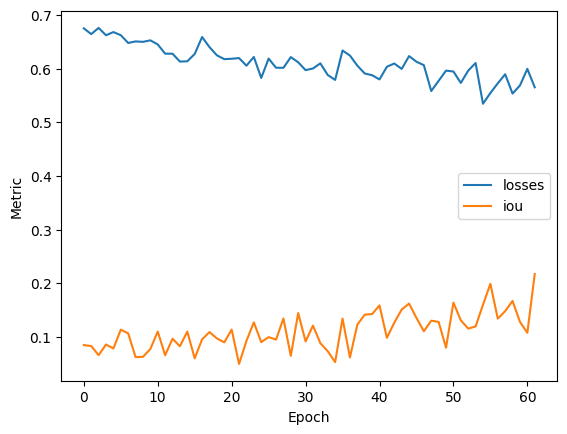

3
	tt [[0.2100609838962555, 0.20799238979816437, 0.15816225111484528, 0.1948804259300232, 0.16591304540634155, 0.2616196572780609, 0.22257307171821594, 0.17377853393554688, 0.15764932334423065, 0.14226588606834412, 0.19652582705020905, 0.12424501031637192, 0.2422705590724945, 0.16511917114257812, 0.14472463726997375, 0.15876369178295135, 0.1251215636730194, 0.2118866890668869, 0.17545340955257416, 0.16129516065120697, 0.22488044202327728, 0.12336347997188568, 0.16991685330867767, 0.15195554494857788, 0.12052401900291443, 0.12177488952875137, 0.13263291120529175, 0.0994303897023201, 0.0783996433019638, 0.06762757897377014, 0.08652793616056442, 0.12314654141664505, 0.058250125497579575, 0.10717476159334183, 0.08933162689208984, 0.08808983117341995, 0.10075651109218597, 0.05013152211904526, 0.12140114605426788, 0.06621335446834564, 0.06442827731370926, 0.052249640226364136, 0.14373520016670227, 0.08272066712379456, 0.06299462169408798, 0.07526175677776337, 0.049435436725616455, 0.06288792

In [ ]:
plt.plot(np.mean(np.array(train_losses),axis=0), label= 'losses')
plt.plot(np.mean(np.array(train_iou),axis=0), label= 'iou')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()
print(len(train_losses),len(train_iou))

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "unet_model.pth")


In [ ]:
import os
import random
from PIL import Image
import torch
import torchvision.transforms as T


In [ ]:
# Path to the images folder
images_path = r"C:\Users\USER\Documents\seismic\test\images"

# Get all image filenames
all_images = [os.path.join(images_path, img) for img in os.listdir(images_path)]

# Randomly select 1,000 images
selected_images = random.sample(all_images, 1000)
print(selected_images[:5])  # Print the first 5 images


['C:\\Users\\USER\\Documents\\seismic\\test\\images\\3606703e6b.png', 'C:\\Users\\USER\\Documents\\seismic\\test\\images\\0dba013816.png', 'C:\\Users\\USER\\Documents\\seismic\\test\\images\\e12852e1cf.png', 'C:\\Users\\USER\\Documents\\seismic\\test\\images\\4f28c879e1.png', 'C:\\Users\\USER\\Documents\\seismic\\test\\images\\a919766328.png']


In [ ]:
transform = T.Compose([
    T.Grayscale(),  # Convert to grayscale if necessary
    T.Resize((96, 96)),  # Resize to match the model's input size
    T.ToTensor(),       # Convert to tensor
])


In [ ]:
model = UnetModel(input_channels=1, output_channels=1).to(device)
model.load_state_dict(torch.load('unet_model.pth'))  # Load trained model weights
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


C:\Users\USER\AppData\Local\Temp\ipykernel_14536\2296917077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model.pth'))  # Load t

UnetModel(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, moment

In [ ]:
results = []

for img_path in selected_images:
    # Open the image
    image = Image.open(img_path)

    # Apply transformations
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.sigmoid(output).cpu().squeeze().numpy()  # Apply sigmoid for binary segmentation

    # Save the result or store it
    results.append((img_path, predicted_mask))

    # Optionally save the mask to a file
    # Example:
    # output_path = img_path.replace("images", "masks").replace(".png", "_mask.png")
    # Image.fromarray((predicted_mask * 255).astype('uint8')).save(output_path)


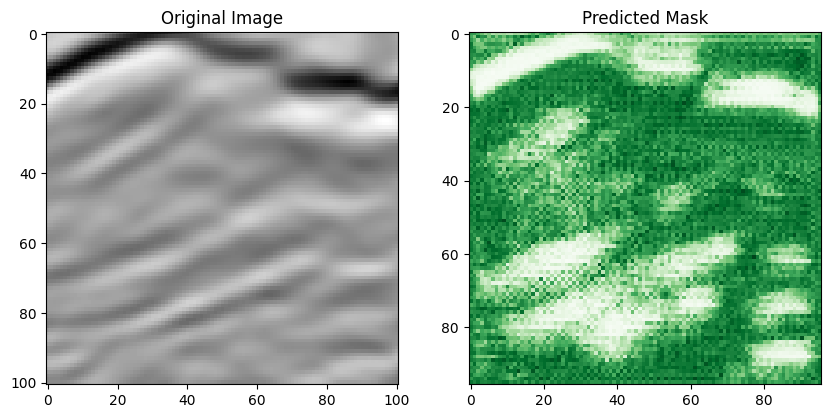

In [ ]:
# Visualize one result
import matplotlib.pyplot as plt

image_path, mask = results[1]
original_image = Image.open(image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(mask, cmap='Greens')

plt.show()
